In [173]:
# imports
# ! pip install easyocr
from easyocr import Reader
# import argparse
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [174]:
current_dir = os.getcwd()

In [175]:
# loading the data required for detecting the license plates using cascade classifier.
plate_cascade_path = os.path.join(current_dir, '../models/haarcascade_ua_license_plate.xml')
plate_cascade = cv2.CascadeClassifier(plate_cascade_path)

In [176]:
def detect_plate(img, text = ''): # the function detects and performs blurring on the number plate.
    plate_img = img.copy() # first copy of the image
    reg_of_intr = img.copy() # second copy of the image
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.4, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        plate = reg_of_intr[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate

In [177]:
def display(img_, title='', fontsize=20):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.title(title, fontsize=fontsize)
    plt.axis('off')
    plt.show()

In [178]:
images = [
    "KA7777XK.jpg",
    "KE7777HT.jpg",
    "KA7777AC.jpg",
    "AB3747BC.jpeg",
    "AO1467BH.jpeg",
    "AA8168YA.jpg",
    "AE1455KH_3.jpg",
    "AE1455KH_4.jpg",
    "KA3713EX.jpg",
    "KA3792KK.jpg",
    "KA2014EX.jpg",
    "KA6003EK.jpg",
    "KA8781IO.jpg",
    "UVVI8I.jpg",
    "BUBO4KA.jpg",
    "AE1455KH_2.jpg",
    "AI2866YA.jpg",
    "KA1088IO.jpg",
    "KA2803IT.jpg",
    "PYTHON.jpg",
    "PYTHON_2.jpg",
    "AE1455KH.jpg",
    "AE3591IT.jpg",
    "A00001A.jpg",
    "AE7094HC.jpg",
    "AR024MI.jpg",
    "AM3808CO.jpg",
    "HH0001OO.jpg",
    "KA7777CA.jpg",
    "KE3198AE.jpeg",
    "SN66XMZ.jpg",
    "BT5390BM.jpg",
    "AA9030PO.jpg",
    "KA2443II.jpg",
    "KA7975II.jpg",
    "NOT4YOU.jpg",
]

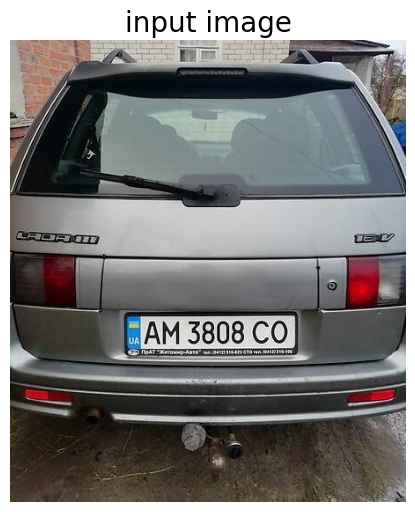

In [179]:
image_path = os.path.join(current_dir, "../images/AM3808CO.jpg")
img = cv2.imread(image_path)
display(img, 'input image')

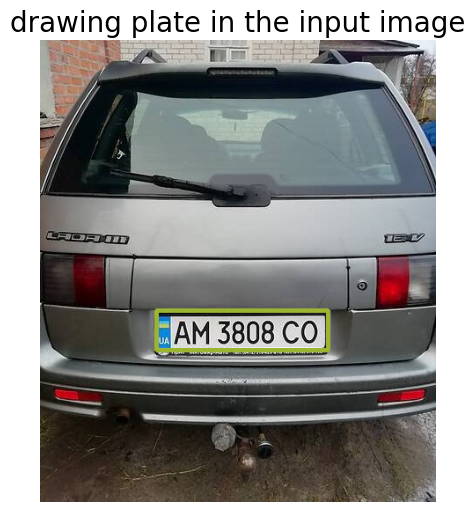

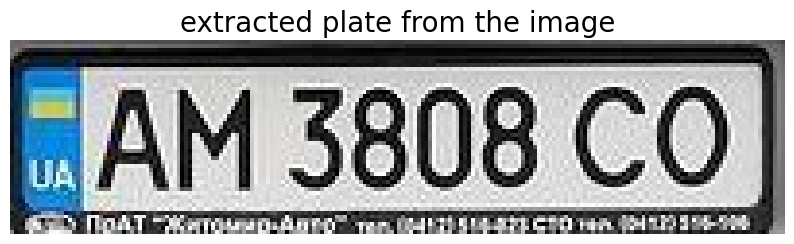

In [180]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, "drawing plate in the input image")
display(plate, "extracted plate from the image")

In [181]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('../images/contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (76, 202, 102), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.axis("off")
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [182]:
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75)) # Resize the image to a fixed size
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Apply binary thresholding
    img_binary_lp = cv2.erode(img_binary_lp, (3,3)) # Apply erosion to remove noise
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3)) # Apply dilation to restore original size

    LP_WIDTH = img_binary_lp.shape[0] # Get the width of the license plate
    LP_HEIGHT = img_binary_lp.shape[1] # Get the height of the license plate

    # Make borders white
    img_binary_lp[0:3,:] = 255 # Minimum character height
    img_binary_lp[:,0:3] = 255 # Maximum character height
    img_binary_lp[72:75,:] = 255 # Minimum character width
    img_binary_lp[:,330:333] = 255 # Maximum character width

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray') # Display the binary image
    plt.axis("off")
    plt.show()
    cv2.imwrite('../images/contour.jpg', img_binary_lp) # Save the binary image to a file

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp) # Find character contours

    return char_list # Return the list of character contours

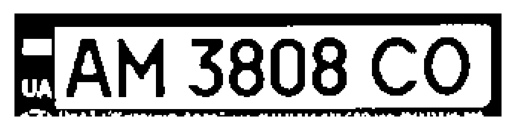

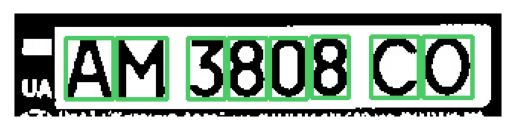

In [183]:
char = segment_characters(plate)

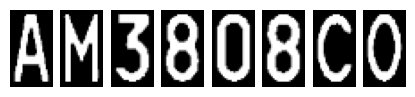

In [184]:
num_chars_to_display = min(10, len(char))

for i in range(num_chars_to_display):
    plt.subplot(1, 10, i+1)
    if i < len(char):
        plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [185]:
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [186]:
# Direct assignments for Jupyter
image_path = "../images/contour.jpg"  # Replace with your image path
langs = ["en"]  # List of languages for OCR
use_gpu = True  # Set to True if you want to use GPU and it's available

In [187]:
# Load the input image from disk
image = cv2.imread(image_path)

In [188]:
# OCR the input image using EasyOCR
# print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(image)
# print(results)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [189]:
# Loop over the results
for bbox, text, prob in results:
    text = text.strip().replace("\n", "").replace(" ", "")
    # print("[INFO] {:.4f}: {}".format(prob, text))
    print("Result:", "\033[33m", text, "\t", "\033[90m", prob, "\033[0m")
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(
        image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2
    )

Result:  UAL 	  0.6363499232071287 
Result:  AM3808CO 	  0.670274757165546 
